# House Prices: Advanced Regression Techniques

## Predict sales prices and practice feature engineering, RFs, and gradient boosting

A Competition from the Kaggle website

Gilles Dejaegere

## 1. Abstract

This works analysis various learning methods by using the "House Prices: Advanced Regression Techniques" competition hosted on [the Kaggle website](http://kaggle.com). To achieve this purpose three learning models have been studied: the linear regression models, the regression tree models and feed forward neural networks. Some feature selection has been tried for each of these models and some ensemble techniques have been tried for linear models and neural networks. 
The evaluation of these models will be done using the root mean square of the logarithm error (RMSLE). Both the linear models and the neural networks perfom correctly, with an error below 0.14.


## 2. Introduction

This project is aimed at predicting the final price of housings in the city of Ames, state of Iowa, United-States. To compute these estimations, a set of roughly 1500 samples with theire 79 respective feature will be used.

The project is structured as follow:

1. Abstract
1. Introduction
1. Data loading, data cleaning and data exploration
    1. Loading and cleaning
    1. Data analysis
1.  Learning models analysis
    1. Linear models
        1. Theorical introduction and summary of the methodology adopted
        1. Simple Linear regression (all features, no powers)
        1. Linear regression with features selection
        1. Ensemble models for Linear regression with feature selection (without powers)
        1. Ensemble models for Linear regression with feature selection (with powers)
        1. Ensemble models for Linear regression with feature selection (with powers, and logarithmic price)
    1. Decision trees
        1. Theorical introduction and summary of the methodology adopted
        1. Regression tree with default parameter
        1. Study of the complexity parameter
        1. Study of the depth parameter
        1. Study of the impact of the minsplit parameter
        1. Forward feature selection
    1. Neural Networks
        1. Parameter and features investigation
        1. Ensemble techniques
1. Conclusion

The model which has been studeid the most in depth is the linear regression model. Therefore, most of the information concernig how I performed my feature selection and my ensemble techniques can be found in section 4 where I have written some explanatory pseudo codes. For the two next models, the ensemble techniques and feature selection functions presented for the linear models are used but not detailed again.

## 3. Data loading, data cleaning and data exploration

### 3.1 Loading and cleaning

As already said, the data set (contained in the file train.csv) contains 1500 samples which are evaluated with 79 features. Unfortunately, some samples have missing evaluations. Furthermore some evaluations consist in categorical variables which are less easy to use. 

To simplify the first analysis, some of these variables will not be considered, and the missing values will be replaced by the median of the evaluations.

However, some of these categorical variables will be conserved for two reasons:

* they represent facets of the problem which are considered as important 
* they can easily be transformed in integer variables

Consider for example the categorical variable **ExterQual**. Its possible values can be mapped as follows:
* Ex - 5
* Gd - 4
* TA - 3
* Fa - 2
* Po - 1

To do so, a function making the mapping has been implemented. This function can be found in the file *clean_data_functions.R*. 

This files also contains functions that removes the remaining categorical variables, and replace the missing values by their median.


In [21]:
# Load raw data in 'data' variable
data<-read.csv("train.csv")

set.seed(0)

source('clean_data_functions.R')

data <- clean_data(data)
data <- data[sample(nrow(data), replace=F),]
# summary(data)
# length(data)

After this operation of data sanitization, there remains 53 features. This preprocessed data will now be split in two variables :
* Y: The feature representig the final price of the housing, which is what must be predicted 
* X: The 52 remaining features that are used to predict that price.

In [22]:
X<-data[,setdiff(colnames(data),"SalePrice")]
Y<-data[,"SalePrice"]

N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables


### 3.2 Data analysis

Now that a clean data set is at our disposal, it would be interresting to investigate it a little before starting the actual machine learning process.

This data investigation is between other inspired of what has been done here : https://www.kaggle.com/notaapple/detailed-exploratory-data-analysis-using-r.

We can for example take start by taking a look at the correlation between the different variables. 

In [23]:
library(corrplot)
corrplot(cor(cbind(X,PriceSold=Y)), method="square")

We can see here that there are some features which are nearly not correlated with any other. In particulary, these variables are not correlated with the price. 

These features will probably not be usefull in some models and will be kept in a variable (to be able to easily remove them from the dataset). 

In [24]:
correlations <- cor(X,Y)

features_not_corr <- which(abs(correlations) < 0.1)

# print(names(X))
# interresting not kept features "MSZoning", "LotShape", "Foundation", "GarageType", "SaleCondition"
 

Let's now analyse a bit further the repartition of the sale prices.

In [25]:

hist(Y)

We can see that this distribution is skrewed. Let's take a look at the distribution of the logarithm of this price :

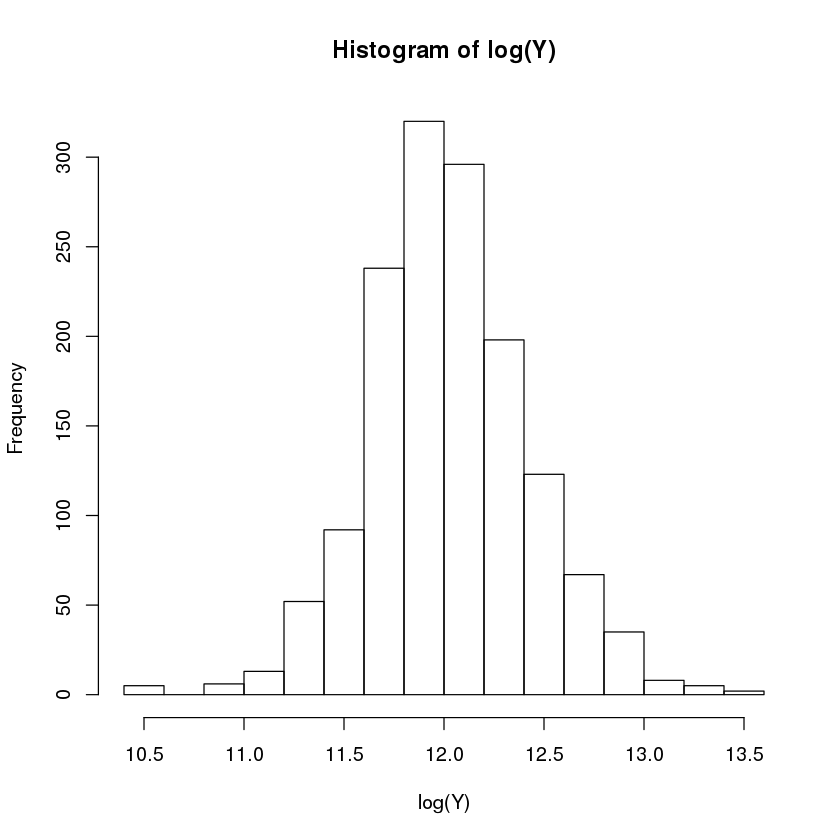

In [26]:
hist(log(Y))

The distribution off the logarithm of the price is more symetric. Maybe it will be a good idea to try to transorm the price in its logarithm before trying to build models.

Since we have to use the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sale price to asses the performences of the algorithms, this value will be computed for the simple prediciting algorithm which always predict the mean of the sales prices:

\begin{equation*}
\frac{\sum_{i=1}^N Y_i}{N}
\end{equation*}

The accuracy of an estimator is computed using the following formula (that will be called RMSLE for Root Mean Square Logarithm error): 

\begin{equation*}
RMSLE= \sqrt{\frac{\sum_{i=1}^N (\log(Y_i) - \log(\hat{Y_i)})^2 }{N}}
\end{equation*}





In [27]:
log.Y.mean <- rep(log(mean(Y)), length(Y))


RMSLE <- sqrt(mean((log.Y.mean - log(Y))^2))


# paste("mean of Y:", format(mean(Y), scientific=T))
print(RMSLE)


[1] 0.4076005


The data set is now ready to build the first models and the first estimations. 

## 4. Learning models analysis

### 4.1 Linear models

#### 4.1.1 Theorical introduction and summary of the methodology adopted

As indicated in the course of [statistical foundations for machine learning](http://uv.ulb.ac.be/course/view.php?id=59893 "uv-page) (slide 14 of linreg.pdf), the simplest linear regression takes the following form:

\begin{equation*}
 \hat{y}=\beta_0+\beta_1 x +w
\end{equation*}

with:

* $x$ being the regressor,
* $\hat{y}$ the mesured reponse,
* $\beta_0$ the interceptor,
* $\beta_1$ the slope, 
* $w$ the model error, with $E[w] = 0$

This simple modelisation could be useful in some situations but is probably to simple to efficiently modelise the problem at hand.

Indeed, since many our input variable are composed of many features, a first necessary improvement of this model would be:

\begin{equation*}
 \hat{y}=\beta_0 +\sum^n_{i=1}\beta_i x_i +w
\end{equation*}

With $n$ being the quantitiy of considered features (all features of the problem do not have to be considered, moreover the $\beta_i$ could be equal to $0$ for some $i$ which would result in the same problem as if this features was not considered). The choice of which of these features will be used is called feature selection and is detailed in the corresponding subsection.

Finally a second elaboration of the model could be done. Indeed, this model is called a linear regression due to the fact that the coefficients ($\beta$) are linear. However nothing impeeds us from using powers of our features as regressors:

\begin{equation*}
 \hat{y}=\beta_0 +\sum^n_{i=1}\sum^m_{j=1}\beta_{ij} x_i^j +w
\end{equation*}

With $m$ being a maximal the maximal accepted power. This $m$ is choosen to avoid overfitting and to limit to computational ressources needed.

This is probably as elaborated as our model will be. 

To compute this model, the $\beta$ minimising the error must be found. To do so, some formula exists (course of [statistical foundations for machine learning](http://uv.ulb.ac.be/course/view.php?id=59893 "uv-page) slide 42 of linreg.pdf):

\begin{equation*}
 \hat{\beta} = (X^T_{(N)}X_{(N)})^{-1} X^T_{(N)}Y_{(N)}
\end{equation*}

This equation, in vectorial notation, computes some estimated values of $\beta$ given $N$ samples of observed $x$ and $y$ (with $x$ representing all the desired powers of all $x_i$).

However, and $R$ function, $lm$ can do all this work for us. 

In this section is subdivided as follow:

* Simple Linear regression (all features, no powers)
* Linear regression with features selection
* Ensemble models for Linear regression with feature selection (without powers)
* Ensemble models for Linear regression with feature selection (with powers)





#### 4.1.2 Simple Linear regression (all features, no powers)

In this section, a really simple linear regression will be tested. This will not give us an efficient model but will allow us to define how the evaluation of a model is done during this work.

The model computed will have the following form: 

\begin{equation*}
 \hat{y}=\beta_0 +\sum^n_{i=1}\sum^m_{j=1}\beta_{ij} x_i^j
\end{equation*}

To compute the best possible models, a data set of roughly 1500 samples ($x$ and $y$ pairs) is at our disposition. However, before trying to produce the best possible model, we will evaluate our overall methodology (which is using a model with the form described here above).

This is done by dividing the 1500 samples in a training set and a testing set. The training set will be used to computed the model, and the testing to evaluate it (since we now the exact y values for all of this pairs). More precisely, a k-fold cross-validation will be applied.

Here under, one can see the pseudo code of this k-fold cross-validation:


```R
function CrossValidation(samples=X, outputs=Y, folds=k) {
    X1, ..., Xk <- random division of X
    Y1, ..., Yk <- same random division but of Y
    errors = 0
    
    for i = 1:k {
        model <- compute a model using all sample but (Xi,Yi)
        Yhat <- use model to predict the output of Xi
        error += compute the RMSLE between Yhat and Yi
    }    
    average_error <- error/k
    return average_error
}
```

This is done here under with the function *linear\_model\_cross\_validation*:

In [28]:
source('linear_analysis.R')

# all features the 52 features are kept:
features <- 1:ncol(X)

folds <- 10

CV_error <- linear_model_cross_validation(X, Y, features, folds)

print(mean(CV_error))




Warning message in predict.lm(model, X.ts):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model, X.ts):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model, X.ts):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model, X.ts):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model, X.ts):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model, X.ts):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model, X.ts):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model, X.ts):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model, X.ts):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model, X.ts):
“prediction from a rank-deficient fit may be misleading”

[1] 0.1815732


Few things should be noted

1. The CV error is about 0.18 which is better than the silly model predicting always the mean of the prices (which is presented at the end of section 2, and which is about 0.4)
1. There are warnings claiming that our input is rank-deficient. What does this mean? This mean that some of the features are nearly linear combinations of others which lead to an infinity of possible solutions for the $\beta$ and which is not appreciated by the lm function.
1. Our linear model often predict negatif prices for the houses. This is of course not realistic. Two solutions have be envisaged. We could remove the 'bad sample' or replace their estimation by the mean of all estimations. The second solution has been choosen for the moment (this choice is done for simplicity purposes, if this problems remains with more elaborated models, maybe a better solution should be found)

Here under, we will try to improve our cross-validation error while also solving the rank deficiency problem by using some feature selection techniques.


#### 4.1.3 Linear regression with features selection

Feature selection consists in trying to build models without using all the features that are at our disposition. This is done generally to avoid what is called over-fitting (building a model which works too well for the training set but which does not work well with the test set, this is due to the fact that our model tries to predict the random noise).

There exist different techniques of features selection:

* PCA: make a change in the coordinates of our points X. This change is not done in a random manner but to optimise the variance of the points on the first *new feature*, then the variance on the second *new feature*, etc. Then, if we choose to keep the $k$ first features, we will have the certainty that they are on the $k$ normal directions where the variance of X is maximal.

* forward feature selection: this is an iterative greedy algorithm. Starting without selecting any feature, the method will add features one by one by selecting the feature which minimize the cross validation error.

* backward feature selection: this is also an iterative greedy algorithm. Instead of starting without any features, start with all features and remove one by one the features in order to minimize the cross validation error.

* ...

We will start by using forward feature selection because it has the advantage of keeping the existing features (without transformation) and the final model will there be more interpretable (note: after the use of ensemble technique, the PCA feature selection did not lead to the best results).

The pseudo code for the forward feautre selection is given here under:

```R
# features are designed with numbers
function forward_feature_selection(samples=X, outputs=Y, folds=k, max_features=f) {
    features_selected <- null
    features_qty <- number of features of X
    features_CV_errors <- empty arry of size features_qty
    for(i=1:f){
        for(j=1:features_qty){
            features_to_include <- features_selected + i
            X_features_includes <- keep features_to_include from X
            features_CV_errors[i] <- CrossValidation(X_features_include, Y, k)
        }
        feature_to_add <- index of min(features_CV_errors)
        features_selected <- features_selected + feature_to_add
    }
    return features_selected
}
```

In [ ]:
source('linear_analysis.R')

set.seed(0)

folds <- 10
max_features <- 30

# ..._lm because its based on a linear model
features <- forward_feature_selection_lm(X, Y, folds, max_features, verbose=T)

features

We can see that the cross validation error is minimal (0.1684) when selection between 22 and 27 features.

The warning due to the rank deficiency has also disapeared. However, our model is still predicting negative prices for some houses.

Here under, one can see the features kept and their correlation with the price sold. The first selected features have a more or less high correlation coefficient with thiis price, but more astonishinly, this is not the case anymore with the other features selected.

In [ ]:

cor(X[,features],Y)

#### 4.1.4 Ensemble models for Linear regression with feature selection (without powers)

One often used technique in machine learning is the use of _Ensemble techniques_. These ensemble techniques consist in averaging the predictions made by different models.

This technique does not diminuish the bias of or model (which are evaluated using the cross validation methodology) but will decrease its variance. 
To understand this distinction we have to understad that until now, our cross validation RMSLE is of about 0.17. But this does not mean that if we tryied our model on a new test sample, the RMSLE always be equal to 0.17! Instead, on average the RMSLE will be close to this value.
To avoid bad surprises, we would like to diminuish the variance of our RMSLE.

To do so, as stated, we will use some ensemble techniques. To perform these techniques optimally we will also do a modification in our feature selected procedure. Indeed, if we use forward selection, we will always obtain very similar sets of features and therefore very similar models. To handle this problem, we will use an forward/backward feature selection with a random starting sets of feature.

The pseudo code of the forward/backward feature selection and of the ensemble technique can be found seen here under:

```R
# features are designed with numbers
function bidirection_feature_selection(samples=X, outputs=Y, folds=k, 
                                       max_features_iteration, starting_features_size ) {
    features_qty <- number of features of X
    features_selected <- random sample of integers between 1 and 'features_qty' 
                         of size 'starting_features_size'
    features_CV_errors <- empty arry of size features_qty
    for(i=1:f){
        for(j=1:features_qty){
            if (i in features_selected){
                features_to_include <- features_selected - i
            }
            else {
                features_to_include <- features_selected + i
            }
            X_features_includes <- keep 'features_to_include' from X
            features_CV_errors[i] <- CrossValidation(X_features_include, Y, k)
        }
        feature_to_add_remove <- index of min(features_CV_errors)
        if (feature_to_add_remove in features_selected){
                features_selected <- features_selected - feature_to_add_remove
            }
            else {
                features_selected <- features_selected + feature_to_add_remove
            }
    }
    return features_selected
}
```

```R
function ensemble_methods_linear_model(X, Y, initial_features_quantity, features_selection_quantity,
                                       folds, model_qty){

    test_set_size <- (number of samples in X)/model_qty
    training_indices, test_indices <- split all indices (1 to number of samples in X) 
                                      with 'test_set_size' indices in 'test_indices'

    predictions <- array of 0 of size 'test_set_size'

    Y_training <- Y[training_indices]
    Y_tests <- Y[test_indices]
    X_test <- X[training_indices] 
    X_test <- X[training_indices] 


    for (i in 1:model_qty) {
        features <- bidirection_feature_selection(X, Y, folds, features_selection_quantity, 
                                                  initial_features_quantity)
 
        model <- compute a model using 'X_training' with 'features' features and 'Y_training' 
        Yhat_i <- use model to predict the output corresponding to 'X_test'
        predictions <- predictions + Yhat_i
    }
    final_Y_hat <- predictions/model_qty
    error <- compute the RMSLE between 'final_Y_hat' and 'Y_test'
    return error
}
```

As it can be seen, the ensemble technique algorithm used is not the same as the one used in the TP. The main difference are:

* Here, the training set is the same for all the models. Why? First because of course, the test set must always be the same in order to perfom siginificant averages (average two outputs for different inputs would not help us in any way), secondly, because I do not believe ressampeling is very interresting in our case. The difference between the models will instead be caused by the fact that we start the feature selection with different random samples of features.

* I do not apply cross-validation on the ensemble techniques. This is done only for computational purposes.
Indeed, for each model, we must already apply a feature selection procedure. This take quite some time already.

In [ ]:
source('linear_analysis.R')
set.seed(0)


features_init <- 10
features_selection_it <- 15
folds <- 10
model_qty <- 10

suppressWarnings(error <- ensemble_methods_linear_model(X, Y, features_init, features_selection_it,
                                                        folds, model_qty, verbose=T))
 

mean(error)
print(error)

We can see that even if I have claimed here above that the error was not supposed to decrease, in if fact decreased (and quite strongly!)! Two hypothesis for this decrease can ve stated :

* The error is lower du to the fact that we didn't compute the cross-validation error but the error of one test set

* The different models computed have opposite biases (some compute prices which are on average on the whole test set to low, while other compute prices which are on average to high).

From now on, for computational purposes, instead of using cross validation, we will compute the error by using the test set of the Kaggle platform and submitting our predictions.

This is done here under:

In [ ]:
source('linear_analysis.R')
source('clean_data_functions.R')

set.seed(0)

raw_test_data <- read.csv('test.csv')
X_test <- clean_data(raw_test_data)
X_test_Id <- raw_test_data[,"Id"]     


features_init <- 10
features_selection_it <- 15
folds <- 10
model_qty <- 10


suppressWarnings(
submission <- make_predictions_ensemble_techniques(X, Y, X_test, X_test_Id, features_init,
                                                   features_selection_it, folds, model_qty)
)

write.csv(submission, 'submission_ensemble_techniques.csv', row.names=F)


The error obtained on the Kaggle platform is equal to 16.2. There is therefore an improvement gained in the error using some ensemble techniques, however, it is far not as drastic as shown just above.

(If you try to reproduce these test, some manipulation of the first row (title) of the csv file could be necessary.)



#### 4.1.5  Ensemble models for Linear regression with feature selection (with powers)

The next step in our research will be to use different powers of the feature of our samples. Our model will therefore have the following shape:

\begin{equation*}
 \hat{y}=\beta_0 +\sum^n_{i=1}\sum^m_{j=1}\beta_{ij} x_i^j +w
\end{equation*}

To do so, we will simply add to our samples some features which are the powers of the existing features. 
The pseudo-code for this procedure is written here under:

```R
function expand_deg_m(X_training, X_test, max_power){
    training <- NULL
    test <- NULL
    
    features_qty <- number of features in X_training
    for (variable in 1: features_qty)){
        for (power in 1:max_power){
            X_var_pow <- feature 'variable' of 'X_training' to the power 'power'
            if (power == 1 OR X_var_pow != feature 'variable' of 'X_training'){
                training <- training + X_var_pow
                test <- test + (feature 'variable' of 'X_test' to the power 'power')
            }
        }
    }
    return training, test
}
```

This step has been kept for the end because it increases highly the computational time required by the feature selection procedure.

In [ ]:
source('linear_analysis.R')
set.seed(0)

raw_test_data <- read.csv('test.csv')
X_test <- clean_data(raw_test_data)
X_test_Id <- raw_test_data[,"Id"]     


features_init <- 10
features_selection_it <- 15
folds <- 10
model_qty <- 10
max_degree <- 3

expanded <- expand_deg_m(X, X_test, max_degree)
X_exp <- expanded$training
X_exp_test <- expanded$test


suppressWarnings(
submission <- make_predictions_ensemble_techniques(X_exp, Y, X_exp_test, X_test_Id, features_init,
                                                   features_selection_it, folds, model_qty)
)

write.csv(submission, 'submission_ensemble_techniques_with_powers.csv', row.names=F)

This submission lead to a score of 0.13981 which is our best result until now with the linear models.

#### 4.1.6  Ensemble models for Linear regression with feature selection (with powers and logarithmic price)

To try to optimize furtheremore our method (this section has been done after the decision tree and neural network analysis), a small modification has been performed. since we observed in section 3 that the distribution of the logarithm of the price was more symetric than the distribution of the price itself, my functions have been modified to build models prediction the logarithm of the price. The idea can be understood using the following pseudo code :

```R
function any_prediction_function(X,Y, X_test) {
    Y_log <- log(Y)
    model <- build model using X, Y_log
    predicition_log <- use model with X_test
    prediction <- 10^prediction_log
}
```

This has been done here under:

In [ ]:
source('linear_analysis.R')

data<-read.csv("train.csv")
set.seed(0)
source('clean_data_functions.R')
data <- clean_data(data)
data <- data[sample(nrow(data), replace=F),]

X<-data[,setdiff(colnames(data),"SalePrice")]
Y<-data[,"SalePrice"]

raw_test_data <- read.csv('test.csv')
X_test <- clean_data(raw_test_data)
X_test_Id <- raw_test_data[,"Id"]

expanded <- expand_deg_m(X, X_test, 3)
X <- expanded$training
X_test <- expanded$test

folds <- 10
features_init_qty <- 15
features_it <- 25
model_qty <- 10
submission <- make_predictions_ensemble_techniques_with_log(X, Y, X_test, X_test_Id, features_init_qty,
                                                            features_it, folds, model_qty)
write.csv(submission, 'submission_lm_log.csv', row.names=F)


The results with this technique where indeed way better and the submission on Kaggle lead to a score of 0.1281. Since This is my best score, I will try to furthermor improve this result by taking into considerations some of the categorical variables which had been kept excluded until now using the *one_hot* technique. This is done here under:

In [ ]:
library(dummies)
one_hot_var <- c("MSZoning", "LotShape", "Foundation", "GarageType", "SaleCondition")

data<-read.csv("train.csv")
set.seed(0)
source('clean_data_functions.R')
data <- clean_data_with_one_hot(data, one_hot_var)
#data <- clean_data(data)
data <- data[sample(nrow(data), replace=F),]


X<-data[,setdiff(colnames(data),"SalePrice")]
Y<-data[,"SalePrice"]


raw_test_data <- read.csv('test.csv')
X_test <- clean_data_with_one_hot(raw_test_data, one_hot_var)
X_test_Id <- raw_test_data[,"Id"]

expanded <- expand_deg_m(X, X_test, 3)
X <- expanded$training
X_test <- expanded$test


folds <- 10
features_init_qty <- 15
features_it <- 20
model_qty <- 10
suppressWarnings(
submission <- make_predictions_ensemble_techniques_with_log(X, Y, X_test, X_test_Id, features_init_qty,
                                                            features_it, folds, model_qty)
)
write.csv(submission, 'submission_lm_log_one_hot.csv', row.names=F)

This, unfortunately didn't lead to an improvement of the Kaggle score (0.13)

### 4.2 Decision Trees

#### 4.2.1 Theorical introduction and summary of the methodology adopted

Decision trees can be represented as tree (graphs) which serves in classifying the samples.
For each sample, at each non terminal node of the tree throug which the sample is directed, a decision is taken according to the sample's evaluation to which child of the concerned node the sample will be directed.

An example of decision which has been taken from the [statistical foundations for machine learning](http://uv.ulb.ac.be/course/view.php?id=59893 "uv-page) (slide 38 of algos.pdf) tree can be found here seen here under:

![alt text](res/decision_tree.png)

In this example, the samples x are classified using two features x1, x2 in 5 categories.

However, we are not considering a classifying problem but a regression one. Therefore, each category will be represented by a price which will be our estimation.

In the rest of this section, we will study the regression trees produced by the *rpart* R function. This section is dicided as follow:

* Regression tree with default parameter
* Study of the complexity parameter
* Study of the depth parameter
* Study of the impact of the minsplit parameter
* Forward feature selection

#### 4.2.2 Regression Tree with default parameters

To have a global idea of what is the performance of a regression tree on this data set, we will first analyse the results obtained with a regression tree using default parameters.

In [ ]:
source('regression_tree_analysis.R')
library('rpart')
library(rpart.plot)
data<-read.csv("train.csv")
source('clean_data_functions.R')

data <- clean_data(data)
set.seed(0)
data <- data[sample(nrow(data), replace=F),]
X<-data[,setdiff(colnames(data),"SalePrice")]
Y<-data[,"SalePrice"]


# use all the features
features <- 1:ncol(X)


suppressWarnings(
model_error <- rpart_cross_validation(X, Y, features, 10, )
)

print(paste('CV error:', mean(model_error$error)))
# The regression tree returned is the one build during the last fold
prp(model_error$model)

#print(control)


We can see from this decision tree that the variables used are *OverallQual* and *GrLivArea* which are the two first features selected by the forward feature selection for linear models (see section 4.1.2). The two following, *TotalBsm* and *YearRemo* where not selected in the five first features of the forward feature selection of the linear model.


#### 4.2.3 Study of the complexity parameter

The rpart function provide by R comes with a bunch of parameters that can be set using the *rpart.control()* function. The first parameter that will be studied is the complexity parameter *cp*.

In the official documentation we can find the following indications for this parameter.

cp:
>  complexity parameter.  Any split that does not decrease the
          overall lack of fit by a factor of ‘cp’ is not attempted.
          For instance, with ‘anova’ splitting, this means that the
          overall R-squared must increase by ‘cp’ at each step. The
          main role of this parameter is to save computing time by
          pruning off splits that are obviously not worthwhile.
          Essentially,the user informs the program that any split which
          does not improve the fit by ‘cp’ will likely be pruned off by
          cross-validation, and that hence the program need not pursue
          it.

In other words, the lowest this value is, the more complex the tree will be (it will be more prone to cut existing nodes in two additional nodes).

In [ ]:
source('regression_tree_analysis.R')
library('rpart')
library(rpart.plot)


features <- 1:ncol(X)

for (complexity in seq(0,0.0002, by=0.00001)){
    control <- rpart.control(cp=complexity)
    set.seed(0)
    suppressWarnings(
    error <- rpart_cross_validation(X, Y, features, 10, control=control)$error
    )
    error <- mean(error)
    print(paste('complexity :', complexity, 'RMSLE :', error))
}

We can see that the best results are obtained with a complexity of 8e-5. Let's take a look at a tree with that complexity:

In [ ]:
source('regression_tree_analysis.R')
library('rpart')
library(rpart.plot)

set.seed(0)

features <- 1:ncol(X)


cp_control <- rpart.control(cp=8e-5)

suppressWarnings(
model_error <- rpart_cross_validation(X, Y, features, 10, control=cp_control)
)

print(mean(model_error$error))
    
pdf('test.pdf')
suppressWarnings(
prp(model_error$model)
)
dev.off()


This tree has been plotted in a pdf since it could not readablily fit this page. 
We can see that indeed, this tree is far more complex than the original tree with default parameters.

We will now try to optimize the the other parameters of the rpart function. This procedure is therefore a greedy procedure since iteratively select the best value for one parameter.

#### 4.2.4 study of the depth parameter

The parameter imposing the maximal depth of the regression tree is *maxdepth* and its definition in the official documentation is the following.

maxdepth: 
> Set the maximum depth of any node of the final tree, with the
          root node counted as depth 0.  Values greater than 30 ‘rpart’
          will give nonsense results on 32-bit machines.
          
My machine is not a 32-bit machine, but I however receive error messages when trying to exceed this limit.


In [ ]:
source('regression_tree_analysis.R')
library('rpart')
library(rpart.plot)

features <- 1:ncol(X)

for (depth in seq(4,30, by=2)){
    set.seed(0)
    control <- rpart.control(cp=8e-5, maxdepth=depth)
    suppressWarnings(
    error <- rpart_cross_validation(X, Y, features, 10, control=control)$error
    )
    error <- mean(error)
    print(paste('depth :', depth, 'RMSLE :', error))
}

We can see that depths greater than 14 do not help diminuishing the error. This is probably simply due to the fact that all trees created during the cross validation procedure have a depth smaller than 14. We will now perfom tests on a last parameter: *minsplit*

#### 4.2.5 Study of the impact of the minsplit parameter

The official documentation gives the following indications for this parameter.

minsplit:

> the minimum number of observations that must exist in a node
          in order for a split to be attempted.


In [ ]:
source('regression_tree_analysis.R')
library('rpart')
library(rpart.plot)

features <- 1:ncol(X)

# recursive search, between 0->100 by 10 gave two good values with minsplit = 20 and 40,
# search between 15 and 45 by 3 gave the best value around 42
for (minsplit in seq(39,45, by=1)){
    set.seed(0)
    control <- rpart.control(cp=8e-5, maxdepth=14, minsplit=minsplit)
    suppressWarnings(
    error <- rpart_cross_validation(X, Y, features, 10, control=control)$error
    )
    error <- mean(error)
    print(paste('minsplit :', minsplit, 'RMSLE :', error))
}

We find that the best value for this parameter is 41. 

We now have 3 values for the parameters : 

* cp=8e-5
* maxdepth = 14
* minsplit = 41

However, we can not yet be sure that this trio is the optimal trio but for now we will accept it as a good enough trio.

We will now apply some feature selection to see wheter it can impove our error.

#### 4.2.6 Forward feature selection

A brief feature selection procedure will be attempted. 

The samples will be divided in subsets, and the feature selection will be done on each of these subsets. This is done to observe if the features selected are always the same.


In [ ]:
source('regression_tree_analysis.R')
library('rpart')
library(rpart.plot)

subsets <- 4
max_features <- 10
selected <- NULL


size.CV <- floor(nrow(X)/10)
for (i in 1:subsets) {
    i_subset_bar <- (((i-1)*size.CV+1):(i*size.CV))  
    i_subset <- setdiff(1:N, i_subset_bar)
    
    X_subset <- X[i_subset,]
    
    Y_subset <- Y[i_subset]
    selected <- rbind(selected, forward_feature_selection_rpart(X_subset, Y_subset, max_features, 
                                                                rpart.control(minsplit=41, maxdepth=14, cp=8e-5)))
}

print(selected)
                    
    

We can see that for each of the subsets, more or less the same features where selected. The total cross validation error computed for a maximal of 30 features on the whole set is computed here under:


In [ ]:
source('regression_tree_analysis.R')
library('rpart')
library(rpart.plot)

max_features <- 30

forward_feature_selection_rpart(X, Y, max_features, rpart.control(minsplit=41, maxdepth=14, cp=8e-5))


### 4.3 Neural networks (feed forward networks)

#### 4.3.1 Theorical introduction and summary of the methodology adopted

A last learning model that will be studied in this work are the feed forward network (FNN). These models are inspired by brains and more particularly from neurons.

FNN are composed of one input layer of neurons, on output layer and some acyclic connectivity structure (which are called hidden units and which are divided in different hidden layers.


A typical feed forward neural network which has been taken from the [statistical foundations for machine learning](http://uv.ulb.ac.be/course/view.php?id=59893 "uv-page) (slide 18 of algos.pdf) can be seen here under:

! [alt text](res/FNN.png)

This is a single hidden layer neural network with two hidden units. This NN has one single output and one single input.

But how does such a network work ?

The output $\hat{Y}$ is simply equal to:

\begin{equation*}
 \hat{y}=g(a_1^{2}(x)) \\
 = g(w_{11}^{(2)}z_1 + w_{21}^{(2)}z_2) \\ 
 = g(w_{11}^{(2)}g(a_1^{(1)}) + w_{21}^{(2)}g(a_2^{(1)})) \\
 = g(w_{11}^{(2)}g(w_{11}^{(1)}x) + w_{21}^{(2)}g(w_{21}^{(1)}x))
\end{equation*}

With:

* $w_{kh}^{l}$ the weight of the link connecting the $k$th node in the $l − 1$ layer and the $h$th node in the $l$ layer
* $z_h$ the output of the $h$th hidden node of the $l$th layer
* $a_h^{l}$ the output of the $h$th hidden unit of the $l$th layer
* $g()$ the activation function which is typically a non linear transformation function like the sigmoid function:

\begin{equation*}
g(z) = \frac{1}{1 + e^{-z}}
\end{equation*}


In the rest of this section, the following points will be aborded:

* Parameters and features investigation
* Ensemble techniques


#### 4.3.2 Parameters and features investigation


Once the activation function is defined, the aim of the learning procedure is to find the values of the weights $w$ which leads to the best matching between our input X and output Y. To do so we will use the *nnet* R functions. These neural networks are networks composed of one hidden layer.

This time I will not make a section for each parameter studied but directly show the results of what I have found using some recursive greedy search (first find best value for the first parameter, then find the best value for the second parameter using the first value found, etc.)

* hidden units : 3
* maxit : 500
* decay : 0.5

Using these values, a simple forward feature selection has been tried. The algorithm for this feature selection is the same used as for linear models.


In [ ]:
library(nnet) 
data<-read.csv("train.csv")
set.seed(0)
source('clean_data_functions.R')
data <- clean_data(data)
data <- data[sample(nrow(data), replace=F),]

X<-data[,setdiff(colnames(data),"SalePrice")]
X_scaled <- data.frame(scale(X))
Y<-data[,"SalePrice"]

N<-nrow(X_scaled)    #Number of examples
n<-ncol(X_scaled)    #Number of input variables


folds <- 5
max_features <- 35

features <- forward_feature_selection_NN(X, Y, folds, max_features, verbose=T, nodes=7, maxit=200, decay=0.3)


We can see that the best results where obtained with 8 features (features 5, 26, 7, 20, 6, 3, 16, 40, 43, 33, 14, 32, 13, 37, 35, 39, 12, 23) with a cross validation error of 0.1291. Now that we have an interesting feature set, optimal values for the parameters have been seached once again. Different values have been found:

* hidden units: 5
* maxit : 500
* decay : 0.3


In [ ]:
# Script to search optimal parameters, play with parameter p

data<-read.csv("train.csv")
set.seed(0)
source('clean_data_functions.R')
data <- clean_data(data)
data <- data[sample(nrow(data), replace=F),]

X<-data[,setdiff(colnames(data),"SalePrice")]
Y<-data[,"SalePrice"]
N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables


#Libraries used
library(nnet) 

X_scaled <- data.frame(scale(X))
features <- c(5, 26, 7, 20, 6, 3, 16, 40, 43, 33, 14, 32, 13, 37, 35, 39, 12, 23)

X_scaled <- X_scaled[,features]
Y_scaled <- scale(Y)

size.CV <- floor(N/10)
CV.err <- numeric(10)

# hidden units searched in seq(1,15, by=1)
for (p in seq(0,1, by=0.1)){
    for (i in 1:10) {
        i.ts <- (((i-1)*size.CV+1):(i*size.CV))  
        X.ts <- X_scaled[i.ts,]                  
        Y.ts <- Y_scaled[i.ts]
        Y.ts_etalon <- Y[i.ts]

        i.tr <- setdiff(1:N,i.ts)                
        X.tr <- X_scaled[i.tr,]
        Y.tr <- Y_scaled[i.tr]                          

        DS<-cbind(X.tr, Price=Y.tr)
        #, maxit=200 , decay=p
        nnmodel <- nnet(Price~., DS, size=5, maxit=500, decay=p, linout=T, trace=F)
        Y.hat.ts <- predict(nnmodel, X.ts)
        Y.hat.ts <- Y.hat.ts*attr(Y_scaled, 'scaled:scale') + attr(Y_scaled, 'scaled:center')
        Y.hat.ts[Y.hat.ts < 0] <- median(Y.hat.ts)
        Y.ts <- Y.ts*attr(Y_scaled, 'scaled:scale') + attr(Y_scaled, 'scaled:center')
        
        # CV.err[i]<- sqrt(mean((log(Y.hat.ts) - log(Y.ts))^2, na.rm=T))
        CV.err[i]<- sqrt(mean((log(Y.hat.ts) - log(Y.ts))^2))
        # nnet_model <- nnet(Price~., DS, size=5, linout=T)   # output is sigmoi : 0-1 thus use linout=T

    }

    print(paste('parameter= ', p, "CV error=", mean(CV.err), " ; std dev=", format(sd(CV.err), scientific=T)))
}

#### 4.3.2 Ensemble techniques

With these parameters, and these features, some ensemble techniques have been tried :

In [ ]:
library(nnet) 
data<-read.csv("train.csv")
set.seed(0)
source('clean_data_functions.R')
data <- clean_data(data)
data <- data[sample(nrow(data), replace=F),]

X<-data[,setdiff(colnames(data),"SalePrice")]
Y<-data[,"SalePrice"]

N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables


folds <- 15
max_features <- 35
features <- c(5, 26, 7, 20, 6, 3, 16, 40, 43, 33, 14, 32, 13, 37, 35, 39, 12, 23)
# features <- c(5, 26, 7, 20, 6, 3, 16, 40, 43, 33, 14, 32, 13, 37, 35, 39, 12, 23, 25, 22, 17, 41)

raw_test_data <- read.csv('test.csv')
X_test <- clean_data(raw_test_data)
X_test_Id <- raw_test_data[,"Id"]     

error <- NN_cross_validation(X, Y, features, folds)
mean(error)

models <- 20

predictions <- NN_ensemble_predicition(X, Y, X_test, features, models, nodes=5, maxit=500, decay=0.3)

write.csv(data.frame('Id'=X_test_Id, 'SalePrice'=predictions), 'submission_NN.csv', row.names=F)

These submission lead to a Kaggle score of 0.1351 which is the best score using neural networks.


## 5. Conclusion

A lot of progess can be done by trying to improve and elaborate some learnings methods. By gradually complexifying our linear models, the error has been decreased from 0.18 to 0.128. 
Tree differents learning methods have been studied in this work. Only the regression tree was not showing interesing results.

Here under one can see a small table summarizing the different results found:

|                   | Basic | Feature Selection | Ensemble Technique | Ensemble Techniques with powers | Ensemble Techniques with powers and Log(Price) | Ensemble Techniques with powers, Log(Price) and One_hot |
|-------------------|-------|-------------------|--------------------|---------------------------------|------------------------------------------------|---------------------------------------------------------|
| Linear Regression | 0.18  | 0.168             | 0.162              | 0.14                            | 12.81                                          | 0.13                                                    |
| Regression Trees  | 0.183 | 0.18              |                    |                                 |                                                |                                                         |
| Neural Networks   |       |  0.129            | 0.135              |                                 |                                                |                                                         |

Note that the value of the basic neural network should be considered with care since it has been obtained with cross validation during the feature selection and not by submitting anything on kaggle. It could therefore be due to some overfitting of the methods on the training set.

Some investigation could still be done:

* Due to computational time requirements, I did not used forward/backward feature selection techniques on other models than the linear model. This technique, combined with ensemble techniques could improve the results obtained with neural networks.
* The *One hot* technique has also only be used with linear models (due to the computational requirements of the feature selection with the neural networks).


